In [1]:
"""

Skript zur generierung von CFADS

"""

print ('_')

_


In [10]:
#!/usr/bin/env python

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import pandas as pd
import wradlib
from scipy import stats
import matplotlib.cm as cm
my_cmap = cm.get_cmap('jet',40)
my_cmap.set_under('lightgrey')
my_cmap.set_over('darkred')
from pcc import get_miub_cmap as my_cmap
from pcc import plot_radar
from pcc import boxpol_pos
from pcc import plot_borders
import wradlib as wrl
from osgeo import osr
from satlib import ipoli_radi
from satlib import corcor
Pos = boxpol_pos()
blon0, blat0 = Pos['lon_ppi'], Pos['lat_ppi']
bbx, bby = Pos['gkx_ppi'], Pos['gky_ppi']

% matplotlib inline

print ("_")

_


# Einlesen von BoXPol Daten
------------------------

In [11]:
ZP = '20141007023744'
#ZP = '20141213140000'
#ZP = '20150330233003'

def CFAD(ZP):
    
    data_, height_ = np.array([]),np.array([])
    
    year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]

    deg_scan =  ["/ppi_1p5deg/","/ppi_2p4deg/","/ppi_3p4deg/",
                 "/n_ppi_010deg/","/n_ppi_045deg/",
                 "/n_ppi_082deg/","/n_ppi_110deg/","/n_ppi_140deg/",
                 "/n_ppi_180deg/","/n_ppi_280deg/"]
    
    for ds in deg_scan:
        
        #print ds
        if year<'2015':
            rad_path = 'radar-archiv'
            
        else:
            rad_path = 'radar'
            
        ppi_datapath=glob.glob('/automount/'+rad_path+'/scans/' + year+ "/" +
                                   year +"-"+ m + "/" + year+ "-" + m +"-"+ d +
                                   ds+ year + "-" + m +"-"+ d + "--" +ht +
                                   ":"+mt+":"+st+",*.mvol")
        print ppi_datapath
        ppi_datapath = ppi_datapath[0]

        #[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']
        ppi=h5py.File(ppi_datapath,'r')
        data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)
        print (data[u'SCAN0'].keys())
        data_boxpol = data[u'SCAN0'][u'ZH']['data']
        r = attrs['SCAN0']['r']
        az = attrs['SCAN0']['az']
        lon_ppi = attrs['VOL']['Longitude']
        lat_ppi = attrs['VOL']['Latitude']
        alt_ppi = attrs['VOL']['Height']
        el_ppi = attrs['SCAN0']['elevation']

        radar_location = (lon_ppi, lat_ppi, alt_ppi)
        elevation = el_ppi
        azimuths = az
        ranges = r
        polargrid = np.meshgrid(ranges, azimuths)
        lon, lat, alt = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1],
                                                         elevation, radar_location)
        #print alt.shape, data_boxpol.shape
        x2 = alt.reshape(alt.shape[0]*alt.shape[1])
        x1 = data_boxpol.reshape(data_boxpol.shape[0]*data_boxpol.shape[1])
        
        height_ = np.append(height_,x2)
        data_ = np.append(data_,x1)

    #print data[u'SCAN0'].keys()
    return data_, height_


In [63]:
def get_my_cmap():
    import matplotlib.cm as cm
    my_cmap = cm.get_cmap('jet',40)
    my_cmap.set_under('white')
    my_cmap.set_over('darkred')
    return my_cmap

def plot_cfad(x1, x2, ZP):
    """
    Plot 4 CFAD
    """
    m1 = ~np.isnan(x1) & ~np.isnan(x2)
    
    x3 = np.array([]); x4 = np.array([]); x5 = np.array([])

    hh = np.array([])
    for jj in range(0,20000,100):
        hh = np.append(hh,jj)
        #x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+100))]))
        #x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+100))]))
    
    plt.figure(figsize=(26,10))
    plt.subplot(2,5,1)
    plt.hist2d(x1[m1], x2[m1],bins=50, cmap=get_my_cmap(), vmin=0.1)
    #plt.hist2d(x1[m1], x2[m1],bins=120, cmap='inferno')
    #plt.hist2d(x1[m1], x2[m1], bins=111, cmap='inferno')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('', fontsize=20, rotation=0)
    cbar.ax.tick_params(labelsize=20) 
    plt.xlabel(r'$Z_H$ in DBz', fontsize=20)
    plt.ylabel('Height in m', fontsize=20)
    plt.title('Elevation: all', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.plot(x3,hh, linewidth=2, label='mean')
    #plt.plot(x4,hh, linewidth=2, label='median')
    plt.ylim(0,7000)
    plt.xlim(0,50)
    #plt.legend(loc='upper right', fontsize=10)
    #plt.grid(color='white')
    #plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/boxpol_cfad_'+ZP+'.png')
    #plt.close()
    plt.savefig('/automount/ftp/velibor/validation/__irs_cfad.png')
    
    plt.show()


In [54]:
#ZP = ('20140806203538','20140826221000','20141007023744','20141008094000','20141008094500',
#'20141213141304','20141217054500','20150128171500','20150225163500',
#'20150330233003','20150404053404','20150626214445','20151015203657','20151211203853','20151216024501',
#'20160209103000','20160601175950','20161109185732','20160107124707','20170211152500','20170211153000')
"""ZP = ('20150225163500',
'20150330233003','20150404053404','20150626214445','20151015203657','20151211203853','20151216024501',
'20160209103000','20160601175950','20161109185732','20160107124707','20170211152500','20170211153000')
for iii in ZP:
    print iii"""

"ZP = ('20150225163500',\n'20150330233003','20150404053404','20150626214445','20151015203657','20151211203853','20151216024501',\n'20160209103000','20160601175950','20161109185732','20160107124707','20170211152500','20170211153000')\nfor iii in ZP:\n    print iii"

In [55]:
x1, x2 = CFAD('20141007023744')

x1[x1<0]=np.nan
#x1[x1> 5]=np.nan

#x2[x2<-5]=np.nan


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_1p5deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_2p4deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_3p4deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_010deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_045deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_082deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_110deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_140deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_180deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_280deg/2014-10-07--02:37:44,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


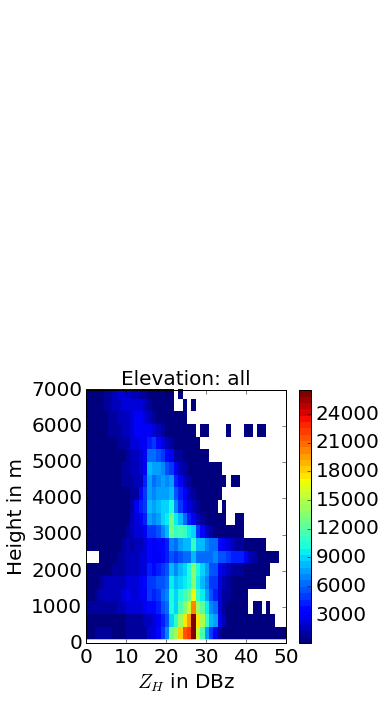

In [64]:
plot_cfad(x1,x2,'20141007023744')


In [ ]:
plot_cfad(x1,x2,'20141007023744')

In [8]:
"""for iii in ZP:
    print type(iii)   
    x1, x2 = CFAD(iii)

    x1[x1<0]=np.nan
    x2[x2<0]=np.nan

    plot_cfad(x1,x2,iii)"""

'for iii in ZP:\n    print type(iii)   \n    x1, x2 = CFAD(iii)\n\n    x1[x1<0]=np.nan\n    x2[x2<0]=np.nan\n\n    plot_cfad(x1,x2,iii)'

In [9]:
iii = '20150128171500'   
x1, x2 = CFAD(iii)

x1[x1<0]=np.nan
x2[x2<0]=np.nan

plot_cfad(x1,x2,iii)

['/automount/radar/scans/2015/2015-01/2015-01-28/ppi_1p5deg/2015-01-28--17:15:00,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


['/automount/radar/scans/2015/2015-01/2015-01-28/ppi_2p4deg/2015-01-28--17:15:00,00.mvol']
[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


[]


IndexError: list index out of range

In [65]:
41-27


14